In [1]:
# External dependencies
import os
import shutil
import numpy as np
from nvtabular.ops import *
from merlin.schema.tags import Tags

import nvtabular as nvt

from os import path

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
df_lib = get_lib()

In [2]:
INPUT_DATA_DIR = os.environ.get(
    "INPUT_DATA_DIR", os.path.join(os.getcwd(), "data/")
)


In [3]:
movies = df_lib.read_parquet(os.path.join(INPUT_DATA_DIR, "movies_converted.parquet"))
movies.head()


,movieId,genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]


In [4]:
CATEGORICAL_COLUMNS = ["userId", "movieId"]
LABEL_COLUMNS = ["rating"]

In [5]:
userId = ["userId"] >> TagAsUserID()
movieId = ["movieId"] >> TagAsItemID()

joined = userId + movieId >> JoinExternal(movies, on=["movieId"])

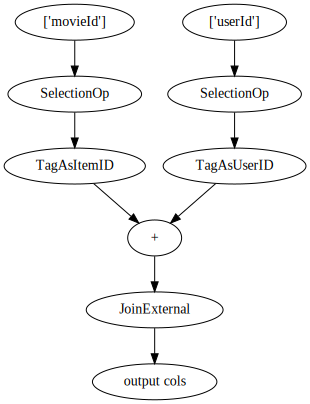

In [8]:
joined.graph


In [9]:
cat_features = joined >> Categorify()


In [10]:
ratings = nvt.ColumnGroup(["rating"]) >> LambdaOp(lambda col: (col > 3).astype("int8")) >> AddTags(Tags.TARGET)


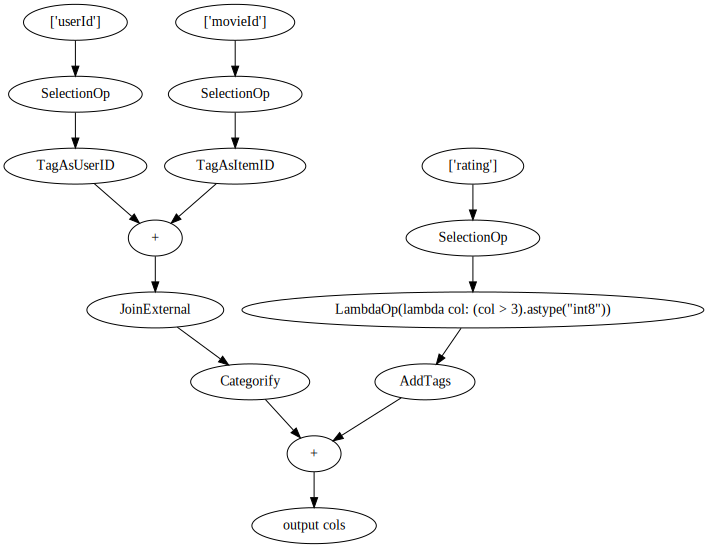

In [11]:
output = cat_features + ratings
(output).graph

In [12]:
workflow = nvt.Workflow(output)


In [13]:
dict_dtypes = {}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64

for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

In [14]:
train_dataset = nvt.Dataset([os.path.join(INPUT_DATA_DIR, "train.parquet")])
valid_dataset = nvt.Dataset([os.path.join(INPUT_DATA_DIR, "valid.parquet")])

/home/martin/anaconda3/envs/nvidia_merlin/lib/python3.7/site-packages/cudf/core/dataframe.py:1254: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  "The deep parameter is ignored and is only included "


In [15]:
%%time
workflow.fit(train_dataset)

CPU times: user 30.6 s, sys: 108 ms, total: 30.7 s
Wall time: 33.4 s


In [16]:
# Make sure we have a clean output path
if path.exists(os.path.join(INPUT_DATA_DIR, "train")):
    shutil.rmtree(os.path.join(INPUT_DATA_DIR, "train"))
if path.exists(os.path.join(INPUT_DATA_DIR, "valid")):
    shutil.rmtree(os.path.join(INPUT_DATA_DIR, "valid"))

In [18]:
%time
workflow.transform(train_dataset).to_parquet(
    output_path=os.path.join(INPUT_DATA_DIR, "train"),
    shuffle=nvt.io.Shuffle.PER_PARTITION,
    cats=["userId", "movieId", "genres"],
    labels=["rating"],
    dtypes=dict_dtypes,
    write_hugectr_keyset=True  # only needed if using this ETL Notebook for training with HugeCTR
                               # should be removed otherwise to speed up computation
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs


In [19]:
%time
workflow.transform(valid_dataset).to_parquet(
    output_path=os.path.join(INPUT_DATA_DIR, "valid"),
    shuffle=False,
    cats=["userId", "movieId", "genres"],
    labels=["rating"],
    dtypes=dict_dtypes,
    write_hugectr_keyset=True  # only needed if using this ETL Notebook for training with HugeCTR
                               # should be removed otherwise to speed up computation
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [20]:
workflow.save(os.path.join(INPUT_DATA_DIR, "workflow"))
workflow.output_schema

[{'name': 'userId', 'tags': {<Tags.CATEGORICAL: 'categorical'>}, 'properties': {'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.userId.parquet', 'domain': {'min': 0, 'max': 162542}, 'embedding_sizes': {'cardinality': 162542, 'dimension': 512}}, 'dtype': dtype('int64'), 'is_list': False, 'is_ragged': False}, {'name': 'movieId', 'tags': {<Tags.CATEGORICAL: 'categorical'>}, 'properties': {'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.movieId.parquet', 'domain': {'min': 0, 'max': 56606}, 'embedding_sizes': {'cardinality': 56606, 'dimension': 512}}, 'dtype': dtype('int64'), 'is_list': False, 'is_ragged': False}, {'name': 'genres', 'tags': {<Tags.CATEGORICAL: 'categorical'>}, 'properties': {'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.genres.parquet', 'domain': {'min': 0, 'max': 21}, 'embedding_sizes': {'ca

In [21]:
import glob

TRAIN_PATHS = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, "train", "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, "valid", "*.parquet")))
TRAIN_PATHS, VALID_PATHS

(['/home/martin/Epita/scia/ML_OPS_TRITON_SERVER/data/train/part_0.parquet'],
 ['/home/martin/Epita/scia/ML_OPS_TRITON_SERVER/data/valid/part_0.parquet'])

In [22]:
df = df_lib.read_parquet(TRAIN_PATHS[0])
df.head()

,userId,movieId,genres,rating
0,72655,329,"[1, 6, 14]",1.0
1,98782,23,[4],1.0
2,172,1060,"[3, 5, 1, 7, 4]",0.0
3,648,1980,"[2, 1]",1.0
4,8517,1843,"[2, 1]",1.0
